In [127]:
import numpy as np
import ceo
import M1S_tools as t
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import griddata
from scipy.ndimage import rotate

In [128]:
# entrance pupil sampling
n_px = 512  #*8 #each measured seg is 853pixels
L = 25.5

In [129]:
gmt = ceo.GMT_MX()
src = ceo.Source('V',rays_box_size=L,rays_box_sampling=n_px)
src>>(gmt,)
+src
pssn0 ,pssn_data = gmt.PSSn(src,save=True)

------
@(CEO)>sources: freeing memory!
 |-@(CEO)>bundle: freeing memory!
@(CEO)>mask: freeing memory!
@(CEO)>modes: loading modes from /home/ubuntu/CEO/gmtMirrors/made-up_mode.ceo
@(CEO)>modes: grid sampling and size: 200 pixel, 8.500000 meter
@(CEO)>modes: number of set: 7 and number of modes per set: 1
@(CEO)>gmt_m1: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
@(CEO)>zernikeS: freeing memory!
@(CEO)>gmt_m2: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
 |-@(CEO)>coordinate_system: freeing memory!
@(CEO)>zernikeS: freeing memory!

@(CEO)>sources:
 zen[arcsec] azim[deg]  height[m]  lambda[micron] magnitude
  0.00        0.00         inf       0.

In [130]:
# "ideal" GMT WFE RMS [nm] & PSSn
src.wavefront.rms(-9),pssn0

(array([0.76414394], dtype=float32), array([1.]))

## Read in a thermal error map

In [131]:
#data = np.load("Data/m1testcell/print-through/outer.pkl",allow_pickle=True)
data = np.load("Data/m1testcell/cold-spot_single/outer.pkl",allow_pickle=True)
#data = np.load("Data/m1testcell/cold-spot_triple/outer.pkl",allow_pickle=True)

nodex_oa = np.asarray(data["nodes"]).reshape(-1,2)[:,0]
nodey_oa = np.asarray(data["nodes"]).reshape(-1,2)[:,1]
s_oa = np.asarray(data["field"])*1e9 #turn into nm
print(s_oa.shape, np.sqrt(s_oa.shape[0]/np.pi))

#data = np.load("Data/m1testcell/print-through/center.pkl",allow_pickle=True) #no difference
data = np.load("Data/m1testcell/cold-spot_single/center.pkl",allow_pickle=True)

nodex_cs = np.asarray(data["nodes"]).reshape(-1,2)[:,0]
nodey_cs = np.asarray(data["nodes"]).reshape(-1,2)[:,1]
s_cs = np.asarray(data["field"])*1e9 #turn into nm
print(s_cs.shape, np.sqrt(s_cs.shape[0]/np.pi))

(27685,) 93.87443314874527
(25794,) 90.61172774108601


In [132]:
print(np.max(nodex_oa)-np.min(nodex_oa), np.max(nodey_oa)-np.min(nodey_oa))
print(np.max(nodex_cs)-np.min(nodex_cs), np.max(nodey_cs)-np.min(nodey_cs))

8.361939079999999 8.362030520000001
8.361944 8.362028


14.70360941020969


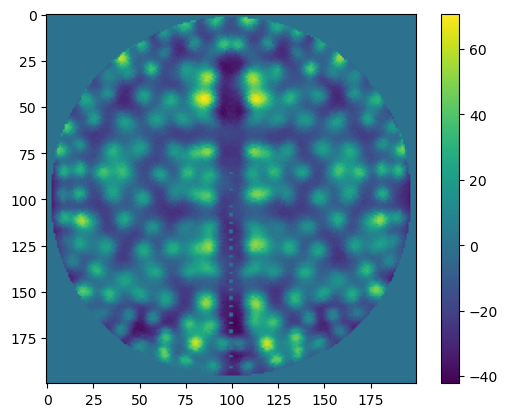

In [133]:
segment_n_px = 200 
m1sArray = np.zeros((segment_n_px, segment_n_px, 7))

segment_L = 8.5
segment_clear_aperture = 8.365
u = np.linspace(-1,1,segment_n_px)
x,y = np.meshgrid(u,u)
r = np.hypot(x,y)
o = np.arctan2(y,x)
idx = ~np.isnan(s_oa)
phase_map_oa = griddata(np.vstack((nodex_oa[idx]/(segment_L/2), nodey_oa[idx]/(segment_L/2))).transpose(), s_oa[idx], (x, y), method='nearest')

fig, ax = plt.subplots()
h = ax.imshow(phase_map_oa*(r<(segment_clear_aperture/segment_L)))
fig.colorbar(h,ax=ax)
aa = phase_map_oa*(r<(segment_clear_aperture/segment_L))
print(np.std(aa[~np.isnan(aa)]))

15.902262875518245


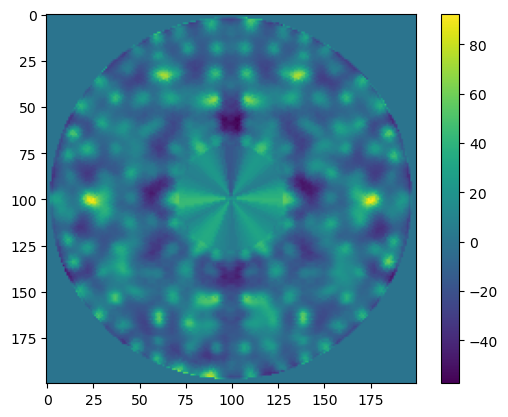

In [134]:
idx = ~np.isnan(s_cs)
phase_map_cs = griddata(np.vstack((nodex_cs[idx]/(segment_L/2), nodey_cs[idx]/(segment_L/2))).transpose(), s_cs[idx], (x, y), method='nearest')

fig, ax = plt.subplots()
h = ax.imshow(phase_map_cs*(r<(segment_clear_aperture/segment_L)))
fig.colorbar(h,ax=ax)
aa = phase_map_cs*(r<(segment_clear_aperture/segment_L))
print(np.std(aa[~np.isnan(aa)]))
#center will be blocked by CEO

In [135]:
for i in range(6):
    m1sArray[:,:,i] = phase_map_oa
m1sArray[:,:,6] = phase_map_cs
phase_map7 = m1sArray.copy() #if there is rotation, add it between m1sArray and phase_map7

In [136]:
np.max(x), np.min(x), np.max(y), np.min(y)

(1.0, -1.0, 1.0, -1.0)

In [137]:
# writing to the "CEO" file format
import os 
from collections import OrderedDict

data = OrderedDict()
data['Ni']     = np.array( segment_n_px, dtype=np.int32)
data['L']      = np.array( segment_L,    dtype=np.double)
data['N_SET']  = np.array( 7,     dtype=np.int32)
data['N_MODE'] = np.array( 1,     dtype=np.int32)
data['s2b']    = np.array( [0,1,2,3,4,5,6], dtype=np.int32) #which segment uses which basis set
data['M'] = phase_map7.flatten(order='F')

path_to_ceo = "/home/ubuntu/CEO/" # CHANGE THIS TO THE CEO PATH ON YOUR MACHINE
filename = "made-up_mode"
path_to_modes = os.path.join( path_to_ceo , 'gmtMirrors' , filename+'.ceo' )
with open(path_to_modes,'w') as f:
    for key in data:
        data[key].tofile(f)

In [138]:
# loading the new mode and setting it up on all M1 segments with 1e-7m amplitude
gmt = ceo.GMT_MX(M1_mirror_modes="made-up_mode",M1_N_MODE=1)
#src = ceo.Source('V',rays_box_size=L,rays_box_sampling=n_px)
state = gmt.state
state["M1"]["modes"][:,0] = -1e-9
gmt^=state
src>>(gmt,)
+src

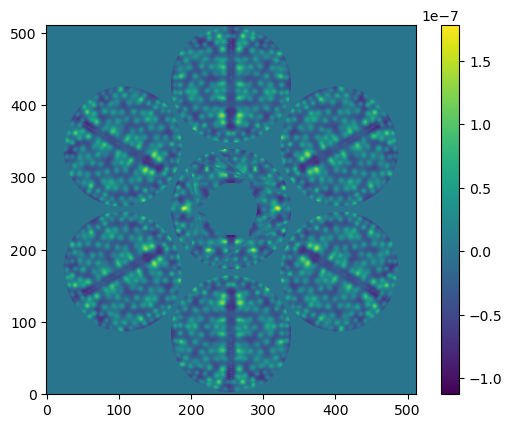

In [139]:
fig, ax = plt.subplots()
h = ax.imshow(src.phase.host(), origin='lower')
fig.colorbar(h,ax=ax)

In [140]:
# "aberrated" GMT WFE RMS [nm] & PSSn
src.wavefront.rms(-9),gmt.PSSn(src,**pssn_data)

(array([31.785732], dtype=float32), array([0.9809297]))